## Introduction
Our project revolves around the use of advanced analytics and Natural Lenguage Processing tools for the recommendation of products close to expiration in supermarkets of the Sailing Group. By accessing the data available on the different APIs offered by the Sailing group, we set to focus on the real-time data of discounted products in order to provide tailored recommendation for the user based on data and feedback the user provides. Initially, we explore simple recommendation techniques based on quantitative metrics such as discounted price and we proceed to create a system that recommends products based on the user's specific wish. Finally, we focus on LLMs and how via prompt engineering they can offer a new prespective and window of opportunity for recommender systems, not only via single-item recommendation but also via generative approaches. 

## Problem Statement

Food waste contributes to environmental and economic loss. Retailers discount items nearing expiry, but many are not discovered in time. Consumers also lack smart tools to decide what to cook based on what they already have or what’s discounted nearby.

Our goal is to combine supermarket clearance data with AI-based recipe generation to help reduce waste and cost simultaneously.


## Fetching Discounted Products from the Salling Group Food Waste API

To retrieve real-time data on discounted food items, we use the Salling Group's public **Food Waste API** (https://developer.sallinggroup.dev/apireference/food-waste). This API provides information on products nearing their expiration date and available at a reduced price in various stores such as Netto, Føtex, and Bilka all over Denmark.


In [1]:
import requests
import pandas as pd
import json

In [2]:
# API token
token = "SG_APIM_CM1M3GXGSA98V8PJ19BQDJPM238NHTTS5TVT7JM7Y2E2VEDBFQQ0"
headers = {
    "Authorization": f"Bearer {token}"
}


In [3]:
# Function that fetches from the food waste API

def fetch_food_waste_data(zip_code):
    url = f"https://api.sallinggroup.com/v1/food-waste/?zip={zip_code}"
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            api_data = response.json()
            if isinstance(api_data, list) and api_data:
                return api_data
            elif isinstance(api_data, dict):
                return [api_data]
            else:
                print("No data from API")
                return []
        else:
            print(f" API request failed with status code {response.status_code}")
            return []
    except Exception as e:
        print(f"Error making API request: {e}")
        return []


### Structure of the data

Below, we can see the structure of the data. There are a lot of different variables to use for further exploration. As can be seen from the dataset the name of the product itself is in Danish and often has added words to it (like manufacturer name etc,) which made it a difficulty to begin with to work with the data. We decided to focus on  the last word under categories_en as the ingredient and using the words before that as broader categories.

In [4]:
import json

api_data = fetch_food_waste_data("2400")

# Access the first product from the first store's clearance list
first_product = api_data[0]["clearances"][0]

# Pretty-print the product with readable Danish characters
print(json.dumps(first_product, indent=2, ensure_ascii=False))


{
  "offer": {
    "currency": "DKK",
    "discount": 9.95,
    "ean": "5712580949505",
    "endTime": "2025-05-05T21:59:59.000Z",
    "lastUpdate": "2025-05-02T06:30:23.000Z",
    "newPrice": 10,
    "originalPrice": 19.95,
    "percentDiscount": 49.87,
    "startTime": "2025-05-02T06:29:44.000Z",
    "stock": 2,
    "stockUnit": "each"
  },
  "product": {
    "categories": {
      "da": "Mejeri & køl>Pålæg>Kødpålæg>Kødpølse",
      "en": "Dairy And Cold Storage>Lunch Meats>Meat>Meat Sausage"
    },
    "description": "JÆGERPØLSE 3-STJERNET",
    "ean": "57067698",
    "image": "https://digitalassets.sallinggroup.com/image/upload/e_trim/c_limit,e_sharpen:80,f_auto,q_auto,w_400,h_400/07daf099-9105-4a99-a16b-7ccf87ad3721"
  }
}


## Recommendation Systems

We decided to create three different recommendation systems. They are all quite similar but very useful for users looking for food waste ingredients.

### Recommended products by discount (1/3)

Here below is a recommendation system in which an user can enter a danish ZIP code, and then there are printed two recommended lists for said user. The first list shows the user the ten products which have the current highest percentage discount within the user's area, and the second list displays the ten products on which the most amount of money is being saved by purchasing them (also within the user's area). The lists both show the products name and in which store within the area code a person can buy the product. Both lists show the current and previous price of the product, the first list display's the discount and the second one money saved.

This type of recommendation system would be considered a personalized one in that all users are receiving the same recommended products, but it is however location based, so that the user can search for an area code and see a list of recommended products from stores within his area code.

In [5]:
import pandas as pd

# Inserting API token:
token = "SG_APIM_CM1M3GXGSA98V8PJ19BQDJPM238NHTTS5TVT7JM7Y2E2VEDBFQQ0"
headers = {
    "Authorization": f"Bearer {token}"
}


# User selects a zip code
selected_zip = input("\nEnter a Danish ZIP code to search stores in: ").strip()

# Fetch food waste data
def fetch_food_waste(zip_code):
    url = f"https://api.sallinggroup.com/v1/food-waste/?zip={zip_code}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

food_waste_data = fetch_food_waste(selected_zip)

# Build DataFrame 
if food_waste_data:
    products = []
    for store in food_waste_data:
        store_name = store.get('store', {}).get('name', 'Unknown Store')
        for item in store.get('clearances', []):
            products.append({
                'description': item.get('product', {}).get('description', ''),
                'category': item.get('product', {}).get('categories', {}).get('en', 'Unknown'),
                'new_price': item.get('offer', {}).get('newPrice', None),
                'original_price': item.get('offer', {}).get('originalPrice', None),
                'percent_discount': item.get('offer', {}).get('percentDiscount', None),
                'stock': item.get('offer', {}).get('stock', None),
                'start_time': item.get('offer', {}).get('startTime', None),
                'end_time': item.get('offer', {}).get('endTime', None),
                'ean': item.get('product', {}).get('ean', None),
                'image_url': item.get('product', {}).get('image', None),
                'store': store_name
            })

    df = pd.DataFrame(products)

    #  Calculate money saved 
    df['money_saved'] = df['original_price'] - df['new_price']

    # The recommendation list
    top_percent_discount = df.sort_values(by='percent_discount', ascending=False).head(10)
    top_money_saved = df.sort_values(by='money_saved', ascending=False).head(10)

    
    print("Top Products by Highest Percentage Discount:")
    for idx, row in top_percent_discount.iterrows():
        print(f"- {row['description']} ({row['store']}): {row['percent_discount']:.1f}% off, now {row['new_price']} DKK (was {row['original_price']} DKK)")

    print("\nTop Products by Most Money Saved:")
    for idx, row in top_money_saved.iterrows():
        print(f"- {row['description']} ({row['store']}): Saved {row['money_saved']:.2f} DKK, now {row['new_price']} DKK (was {row['original_price']} DKK)")

else:
    print("No data fetched.")

Top Products by Highest Percentage Discount:
- MADLAVNING 15% AMA (Netto Tuborgvej): 78.5% off, now 3 DKK (was 13.95 DKK)
- JAVISST PÅGEN (Netto Lygten): 75.0% off, now 6 DKK (was 23.95 DKK)
- BACON POSTEJ STRYHNS (Netto Tuborgvej): 73.3% off, now 8 DKK (was 29.95 DKK)
- RØD I SKIVER PRIMA DONNA (Netto Tuborgvej): 68.5% off, now 11 DKK (was 34.95 DKK)
- HERKULES KOHBERG (Netto Tomsgårdsvej): 63.5% off, now 8 DKK (was 21.95 DKK)
- BACON POSTEJ STRYHNS (Netto Tomsgårdsvej): 63.3% off, now 11 DKK (was 29.95 DKK)
- SOLSTYKKER PÅGEN (Netto Tomsgårdsvej): 62.4% off, now 9 DKK (was 23.95 DKK)
- RØGET FILET PÅLÆKKER (Netto Tuborgvej): 61.0% off, now 7 DKK (was 17.95 DKK)
- RISOTTO TRØFFEL NÆMT (Netto Tomsgårdsvej): 60.0% off, now 12 DKK (was 30.0 DKK)
- BACON LEVERPOSTEJ TULIP (Netto Lygten): 59.9% off, now 8 DKK (was 19.95 DKK)

Top Products by Most Money Saved:
- SKÆRE 45+ H.C. ANDERSE (Netto Tomsgårdsvej): Saved 49.00 DKK, now 50 DKK (was 99.0 DKK)
- SVINEMØRBRAD VELSMAG (Netto Frederikssun

### Recommendation system (2/3)

The recommendation system that the code below provides is very similar to the one above. It does provide two lists (the products with the highest discount and the products with the highest money saved) and it does also give the user an option to type in an area code to see the products on sale within his area. The main difference for these lists is that the recommendation system provides recommended products for each food category within the area code.

In [6]:


# Inserting API token
token = "SG_APIM_CM1M3GXGSA98V8PJ19BQDJPM238NHTTS5TVT7JM7Y2E2VEDBFQQ0"
headers = {
    "Authorization": f"Bearer {token}"
}



# User selects a ZIP code 

selected_zip = input("\nEnter a Danish ZIP code to search stores in: ").strip()

# Fetch food waste data 
def fetch_food_waste(zip_code):
    url = f"https://api.sallinggroup.com/v1/food-waste/?zip={zip_code}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

food_waste_data = fetch_food_waste(selected_zip)

# Build DataFrame 
if food_waste_data:
    products = []
    for store in food_waste_data:
        store_name = store.get('store', {}).get('name', 'Unknown Store')
        for item in store.get('clearances', []):
            products.append({
                'description': item.get('product', {}).get('description', ''),
                'category': item.get('product', {}).get('categories', {}).get('en', 'Unknown'),
                'new_price': item.get('offer', {}).get('newPrice', None),
                'original_price': item.get('offer', {}).get('originalPrice', None),
                'percent_discount': item.get('offer', {}).get('percentDiscount', None),
                'stock': item.get('offer', {}).get('stock', None),
                'start_time': item.get('offer', {}).get('startTime', None),
                'end_time': item.get('offer', {}).get('endTime', None),
                'ean': item.get('product', {}).get('ean', None),
                'image_url': item.get('product', {}).get('image', None),
                'store': store_name
            })

    df = pd.DataFrame(products)

    # Calculate money saved 
    df['money_saved'] = df['original_price'] - df['new_price']

    # Extract first category 
    df['first_category'] = df['category'].apply(lambda x: x.split('>')[0] if isinstance(x, str) and '>' in x else x)

    # For each category, print Top 3 products (max)
    categories = [cat for cat in df['first_category'].dropna().unique() if cat != "Unknown"]

    for cat in categories:
        df_cat = df[df['first_category'] == cat]

        top_percent_discount = df_cat.sort_values(by='percent_discount', ascending=False).head(3)
        top_money_saved = df_cat.sort_values(by='money_saved', ascending=False).head(3)

        print(f"\n Category: {cat}")

        print("\n Top products by Highest Percentage Discount:")
        for idx, row in top_percent_discount.iterrows():
            print(f"- {row['description']} ({row['store']}): {row['percent_discount']:.1f}% off, now {row['new_price']} DKK (was {row['original_price']} DKK)")

        print("\n Top products by Most Money Saved:")
        for idx, row in top_money_saved.iterrows():
            print(f"- {row['description']} ({row['store']}): Saved {row['money_saved']:.2f} DKK, now {row['new_price']} DKK (was {row['original_price']} DKK)")

else:
    print("No data fetched.")


 Category: Dairy And Cold Storage

 Top products by Highest Percentage Discount:
- MADLAVNING 15% AMA (Netto Tuborgvej): 78.5% off, now 3 DKK (was 13.95 DKK)
- BACON POSTEJ STRYHNS (Netto Tuborgvej): 73.3% off, now 8 DKK (was 29.95 DKK)
- RØD I SKIVER PRIMA DONNA (Netto Tuborgvej): 68.5% off, now 11 DKK (was 34.95 DKK)

 Top products by Most Money Saved:
- SKÆRE 45+ H.C. ANDERSE (Netto Tomsgårdsvej): Saved 49.00 DKK, now 50 DKK (was 99.0 DKK)
- SKÆRE 45+ H.C. ANDERSE (Netto Tuborgvej): Saved 36.00 DKK, now 63 DKK (was 99.0 DKK)
- TARTELETFYLD PREMIEUR (Netto Tomsgårdsvej): Saved 25.00 DKK, now 25 DKK (was 50.0 DKK)

 Category: Beverages

 Top products by Highest Percentage Discount:
- SMOOTHIE 250ML FRUGTKOMPAG. (Netto Tuborgvej): 45.2% off, now 6 DKK (was 10.95 DKK)
- INGEFÆR/HINDBÆR ØGO (Netto Tuborgvej): 40.0% off, now 3 DKK (was 5.0 DKK)
- VITAMIN SMOOTHIE VALSØLILLE (Netto Emdrupvej): 30.3% off, now 16 DKK (was 22.95 DKK)

 Top products by Most Money Saved:
- VITAMIN SMOOTHIE VAL

### Recommendation system (3/3)

This final variation of the recommendation system allows an user to write in an area code (same as before) but it takes it a step further and then allows the user to pick a store within that area code. Then the recommendation system provides the two lists of recommended products that are on sale within the store (list for products with the highest discount, and a list for products which save you the highest amount of money).

In [7]:
# Insert API token
token = "SG_APIM_CM1M3GXGSA98V8PJ19BQDJPM238NHTTS5TVT7JM7Y2E2VEDBFQQ0"
headers = {
    "Authorization": f"Bearer {token}"
}



# User selects a ZIP code
selected_zip = input("\nEnter a Danish ZIP code to search stores in: ").strip()

# Fetch food waste data 
def fetch_food_waste(zip_code):
    url = f"https://api.sallinggroup.com/v1/food-waste/?zip={zip_code}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

food_waste_data = fetch_food_waste(selected_zip)

# Let user choose a store
if food_waste_data:
    store_names = []
    store_lookup = {}
    for i, store in enumerate(food_waste_data):
        store_name = store.get('store', {}).get('name', f"Store #{i}")
        full_name = f"{store_name} - {store.get('store', {}).get('address', {}).get('street', '')}"
        store_names.append(full_name)
        store_lookup[str(i)] = store

    print("\nStores found in this area:")
    for i, name in enumerate(store_names):
        print(f"{i}: {name}")

    selected_index = input("\nSelect a store by number: ").strip()
    if selected_index not in store_lookup:
        print("Invalid selection. Exiting.")
        exit()

    selected_store = store_lookup[selected_index]

    # Build DataFrame 
    store_name = selected_store.get('store', {}).get('name', 'Unknown Store')
    products = []
    for item in selected_store.get('clearances', []):
        products.append({
            'description': item.get('product', {}).get('description', ''),
            'category': item.get('product', {}).get('categories', {}).get('en', 'Unknown'),
            'new_price': item.get('offer', {}).get('newPrice', None),
            'original_price': item.get('offer', {}).get('originalPrice', None),
            'percent_discount': item.get('offer', {}).get('percentDiscount', None),
            'stock': item.get('offer', {}).get('stock', None),
            'start_time': item.get('offer', {}).get('startTime', None),
            'end_time': item.get('offer', {}).get('endTime', None),
            'ean': item.get('product', {}).get('ean', None),
            'image_url': item.get('product', {}).get('image', None)
        })

    df = pd.DataFrame(products)

    # Calculate money saved 
    df['money_saved'] = df['original_price'] - df['new_price']

    # Recommended products
    top_percent_discount = df.sort_values(by='percent_discount', ascending=False).head(10)
    top_money_saved = df.sort_values(by='money_saved', ascending=False).head(10)

    print(f"\n Showing products for store: {store_name}")

    print("\n Top Products by Highest Percentage Discount:")
    for idx, row in top_percent_discount.iterrows():
        print(f"- {row['description']}: {row['percent_discount']:.1f}% off, now {row['new_price']} DKK (was {row['original_price']} DKK)")

    print("\n Top Products by Most Money Saved:")
    for idx, row in top_money_saved.iterrows():
        print(f"- {row['description']}: Saved {row['money_saved']:.2f} DKK, now {row['new_price']} DKK (was {row['original_price']} DKK)")

else:
    print("No data fetched.")


Stores found in this area:
0: Netto Emdrupvej - Emdrupvej 107
1: Netto Frederikssundsvej 52 - Frederikssundsvej 52 ST.
2: Netto Utterslevvej - Utterslevvej 11
3: Netto Tomsgårdsvej - Tomsgårdsvej 24
4: Netto Lygten - Lygten 53
5: Netto Stærevej - Stærevej 74
6: Netto Tuborgvej - Tuborgvej 239

 Showing products for store: Netto Frederikssundsvej 52

 Top Products by Highest Percentage Discount:
- KARTOFFEL SANDWICH KOHBERG: 53.2% off, now 7 DKK (was 14.95 DKK)
- BACON POSTEJ STRYHNS: 49.9% off, now 15 DKK (was 29.95 DKK)
- FRANSK LEVERPOSTEJ STRYHNS: 49.9% off, now 15 DKK (was 29.95 DKK)
- ROASTBEEF SMAGEN AF AARHUS: 49.9% off, now 10 DKK (was 19.95 DKK)
- SAN. KYL. TOMAT PÅLÆKKER: 49.8% off, now 8 DKK (was 15.95 DKK)
- MULTIKERNE BOLLER SCHULSTAD: 48.0% off, now 13 DKK (was 25.0 DKK)
- KERNERUGBRØD ØGO: 43.6% off, now 9 DKK (was 15.95 DKK)
- KRYDDERBOLLER GAMLE MØLLE: 41.2% off, now 5 DKK (was 8.5 DKK)
- RISOTTO CHAMPIG NÆMT: 40.0% off, now 18 DKK (was 30.0 DKK)
- FULDKORNSBOLLER SCH

## Search Engine

Next we wanted to build a Semantic Discount-Based Product Recommender and use it as a search engine for the user.


### Preparing data for the search engine

After retrieving raw food clearance data from the Salling Group API, it is necessary to convert this nested JSON structure into a clean, usable DataFrame. The function `create_products_dataframe()` performs this transformation.

This function iterates through the list of stores and their clearance products, extracting:
- Store details (name and street)
- Product information (description, pricing, discounts)
- Hierarchical product categories (split into `category1` through `categoryN`) since products have different number of sub categories.

To support category-based filtering and semantic similarity tasks, the full category path is split into components. The most specific category is assigned as `final_category`, which becomes key for embedding and recommendation later on.

In [8]:
#function that creates a dataframe from the API

def create_products_dataframe(api_data_list, zip_code, max_splits=10):
    products = []

    if not api_data_list:
        print(f" No data returned for ZIP {zip_code}")
        return pd.DataFrame()

    for store_data in api_data_list:
        clearances = store_data.get("clearances", [])
        store_info = store_data.get("store", {})
        store_name = store_info.get("name", "Unknown Store")
        store_address = store_info.get("address", {})
        store_street = store_address.get("street", "Unknown Street")

        if not clearances:
            continue

        for item in clearances:
            try:
                product = item.get("product", {})
                offer = item.get("offer", {})

                categories = product.get("categories", {})
                category_full = categories.get("en") or categories.get("da") or ""

                # Extract category splits (and pad)
                parts = [p.strip() for p in category_full.split(">")]
                parts += [""] * (max_splits - len(parts))

                row_data = {
                    "zip_code": zip_code,
                    "store_name": store_name,
                    "store_street": store_street,
                    "description": product.get("description", ""),
                    "original_price": offer.get("originalPrice"),
                    "new_price": offer.get("newPrice"),
                    "discount": offer.get("discount"),
                }

                # Assign category1 through categoryN
                for i in range(max_splits):
                    row_data[f"category{i+1}"] = parts[i]

                # Set final_category as the last non-"Unknown" category from the parts
                final = next((cat for cat in reversed(parts) if cat != ""), "")
                row_data["final_category"] = final

                products.append(row_data)

            except Exception as e:
                print(f"Skipping item due to error: {e}")
                continue

    return pd.DataFrame(products)


In [9]:
zip_codes = [2400]

all_products = [] 

for zip_code in zip_codes:
    api_data = fetch_food_waste_data(zip_code)
    df = create_products_dataframe(api_data, zip_code)
    all_products.append(df)

df_all_products = pd.concat(all_products, ignore_index=True)


print(df_all_products.head())


   zip_code       store_name   store_street              description  \
0      2400  Netto Emdrupvej  Emdrupvej 107    JÆGERPØLSE 3-STJERNET   
1      2400  Netto Emdrupvej  Emdrupvej 107    HAMBURGERRYG PÅLÆKKER   
2      2400  Netto Emdrupvej  Emdrupvej 107   BEARNAISESAUCE JENSENS   
3      2400  Netto Emdrupvej  Emdrupvej 107  BACON BEARNAISE JENSENS   
4      2400  Netto Emdrupvej  Emdrupvej 107           BUTTERDEJ NÆMT   

   original_price  new_price  discount               category1  \
0           19.95         10      9.95  Dairy And Cold Storage   
1           15.95          9      6.95  Dairy And Cold Storage   
2           15.95          8      7.95  Dairy And Cold Storage   
3           10.00          7      3.00                           
4           13.95         11      2.95  Dairy And Cold Storage   

                  category2    category3              category4 category5  \
0               Lunch Meats         Meat           Meat Sausage             
1               

In [10]:
df_all_products.to_csv("food_waste_ingredients.csv", index=False)

### Semantic Discount-Based Product Recommender 

To enhance user decision-making and promote sustainable consumption, we created a semantic product recommender. This component helps users discover relevant, discounted products that are either direct matches or semantically similar to what they searched for.

#### Why Semantic Similarity?

In the beginning, we considered clustering products into groups using KMeans. However, due to the relatively small and inconsistent number of discounted products returned per API request the clustering turned out to be ineffective.

Instead, we decided to use a semantic similarity approach using pretrained language models. This method treats product descriptions and categories as meaningful text and finds similarities between them, regardless of word form or position.

We use `'all-MiniLM-L6-v2'` from the Sentence Transformers library to convert text into high-dimensional vector representations (embeddings). These embeddings allow us to compute similarity between any two products using cosine similarity.

#### Methodology

1. **User Input:** The user enters a product name they are interested in (For example cheese).
2. **Vector Encoding:** The system finds the vector embedding for that product using its category and description text.
3. **Similarity Calculation:** Cosine similarity is computed between that vector and all others in the dataset.
4. **Filtering:** Only items above a similarity threshold are retained (> 0,4 in this case)
5. **Ranking:** Results are sorted by both similarity score and discount percentage. Showing relevant and affordable alternatives.

#### User Experience

From the user’s perspective, this recommender works as a product search engine. Allowing users to type in any product they want and see if something relevant is on discount nearby. 

This helps users:
- Reduce grocery costs
- Discover discounted alternatives they might not consider on their own
- Avoid manually browsing through categories or entire store inventories
- Make faster, more informed shopping decisions


In [11]:
# Load dataset
data = pd.read_csv('food_waste_ingredients.csv')

# Remove rows with no English description.
data = data[data['final_category'] != ''].reset_index(drop=True)

# Remove ready meals
data = data[data['category2'] != 'Ready To Eat Meals'].reset_index(drop=True)

To make the recommendation system as accurate as possible. We combined all categories into one long string.

In [12]:
# Combine categories to create a more efficient embedding.
data['text_for_embedding'] = (
    data['category1'].astype(str) + " " +
    data['category2'].astype(str) + " " +
    data['category3'].astype(str) + " " +
    data['category4'].astype(str) + " " +
    data['category5'].astype(str) + " " +
    data['category6'].astype(str) + " " +
    data['category7'].astype(str) + " " +
    data['category8'].astype(str) + " " +
    data['category9'].astype(str) + " " +
    data['category10'].astype(str) + " " +
    data['final_category'].astype(str)
)

In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [14]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
product_texts = data['text_for_embedding'].tolist()
embeddings = model.encode(product_texts, show_progress_bar=True)

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
# Function that recommends products based on semantic similarity and discount.

def recommend_semantic_discounted(product_name, top_n=5, similarity_threshold=0.4):

    # Find products in the dataset that matches the name
    matches = data[data['text_for_embedding'].str.contains(product_name, case=False, na=False)]

    if matches.empty:
        print(f"No product found with name containing '{product_name}'.")
        print("\nHere are some valid examples you can try:")
        print(data['final_category'].drop_duplicates().sample(5, random_state=42).tolist())
        return None

    # Use the first match to get the embedding
    index = matches.index[0]
    input_vector = embeddings[index]

    # Compute cosine similarity with all products
    scores = cosine_similarity([input_vector], embeddings)[0]
    data['similarity'] = scores

    # Filter products with sufficient similarity
    similar_items = data[
        (data.index != index) &
        (data['similarity'] >= similarity_threshold)
    ].copy()

    # Sort by similarity and discount, drop duplicates by category
    similar_items = (
        similar_items
        .sort_values(by=['similarity', 'discount'], ascending=[False, False])
        .drop_duplicates(subset=['final_category'])
        .head(top_n)
    )

    # Rename column headers for display
    similar_items = similar_items.rename(columns={
        'zip_code': 'ZIP Code',
        'description': 'Product Description',
        'store_name': 'Store',
        'store_street': 'Street',
        'final_category': 'Ingredient',
        'category1': 'Top Category',
        'original_price': 'Original Price (DKK)',
        'new_price': 'Discounted Price (DKK)',
        'discount': 'Discount (DKK)',
        'similarity': 'Semantic Similarity Score'
    })

    # Show matched input info
    print(" Found product info:")
    print(data.loc[index, ['final_category', 'zip_code', 'store_name', 'store_street']])

    # Return the selected and renamed columns
    return similar_items[[
        'ZIP Code',
        'Product Description',
        'Store',
        'Street',
        'Ingredient',
        'Top Category',
        'Original Price (DKK)',
        'Discounted Price (DKK)',
        'Discount (DKK)',
        'Semantic Similarity Score'
    ]]


In [16]:
recommend_semantic_discounted("cheese")

 Found product info:
final_category    Blue Cheese Brie
zip_code                      2400
store_name         Netto Emdrupvej
store_street         Emdrupvej 107
Name: 22, dtype: object


,ZIP Code,Product Description,Store,Street,Ingredient,Top Category,Original Price (DKK),Discounted Price (DKK),Discount (DKK),Semantic Similarity Score
161,2400,BRIE PRÉSIDENT,Netto Tomsgårdsvej,Tomsgårdsvej 24,Blue Cheese Brie,Dairy And Cold Storage,35.95,19,16.95,1.000000
166,2400,HVID/PURLØG ØKO NATURLI,Netto Tomsgårdsvej,Tomsgårdsvej 24,Cream Cheese,Dairy And Cold Storage,20.00,13,7.00,0.882537
214,2400,HYTTEOST PROTEIN LAB,Netto Stærevej,Stærevej 74,Cottage Cheese,Dairy And Cold Storage,12.95,8,4.95,0.864840
292,2400,45+ ML SKIVER KLOVBORG,Netto Tuborgvej,Tuborgvej 239,Sliced Cheese,Dairy And Cold Storage,45.00,26,19.00,0.835941
175,2400,LAGRET HAVARTI CASTELLO,Netto Tomsgårdsvej,Tomsgårdsvej 24,Cheese Specialities,Dairy And Cold Storage,45.00,27,18.00,0.826489


## Recipe Generator using LLM

What needs to be done is the following:

a) If possible to make continous, then make LLM create a matrix with missing ingredients(in danish without measures) and runs that through the function to fetch cheapest prices

b) Add the price of the food waste ingredients to the missing ingredients to find the total price of the recipe. Maybe show the cost saved as well.

c) Would be cool to add the name of the recipe above the table below (* Chicken curry *)

In [ ]:
import openai
import os

# Inserting OpenAI token:
client = openai.OpenAI(api_key="")

def generate_recipe_from_danish_ingredient(ingredient_dk):
    prompt = f"""
Create a detailed recipe in DANISH that uses the following Danish ingredient: "{ingredient_dk}".
The ingredient list should be written in DANISH.
Include:
- A creative recipe title
- A short 1-2 sentence description
- A list of ingredients (in Danish)
- Step-by-step instructions (in Danish)
"""

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a professional chef that creates creative and easy-to-follow recipes."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=700
    )

    return response.choices[0].message.content

# User input
ingredient = input("Enter a Danish ingredient from the food waste list: ")
recipe = generate_recipe_from_danish_ingredient(ingredient)

# Printing the recipe
print("\nHere is your recipe:\n")
print(recipe)

Below, we used another Sailing Group API. Where you can search for an ingredient (in Danish) and it will give you relevant products sold at Bilka. 

We can use that API, to find the cheapest ingredients which are missing to create the generated recipe and optimize the cost by choosing the cheapest ingredients. https://developer.sallinggroup.dev/apireference/product-suggestions

In [23]:
import requests
import pandas as pd

# Replace with your token
token = "SG_APIM_HMARAVTQFBDNMSBC5XGVGQFP395APFF4MAV2C99FBAAZV6Q6TZ6G"
headers = {
    "Authorization": f"Bearer {token}"
}

# BilkaToGo suggestion search
def get_relevant_bilka_products(query):
    url = f"https://api.sallinggroup.com/v1/product-suggestions/relevant-products?query={query}"
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        return response.json().get("suggestions", [])
    else:
        print(f"Error {response.status_code}: Failed to fetch for '{query}'")
        return []

# Main function to find cheapest product per ingredient
def find_cheapest_bilka_options(ingredient_list):
    results = []

    for ingredient in ingredient_list:
        suggestions = get_relevant_bilka_products(ingredient)

        if not suggestions:
            results.append({
                "ingredient": ingredient,
                "product_name": "Not found",
                "price": None,
                "link": None
            })
            continue

        # Find the product with the lowest price
        cheapest = min(suggestions, key=lambda x: x.get("price", float('inf')))

        results.append({
            "ingredient": ingredient,
            "product_name": cheapest.get("title"),
            "price": cheapest.get("price"),
            "link": cheapest.get("link")
        })

    return pd.DataFrame(results)


Here we can see how the API works for the missing ingredients.

In [24]:
# Example: Missing ingredients from LLM-generated recipe
missing_ingredients = ["mælk", "kyllingebryst", "gulerødder", "løg"]
recipe_name = "Curry chicken"  # Replace dynamically if needed

# Get cheapest options from the API
df_cheapest = find_cheapest_bilka_options(missing_ingredients)

# Rename columns for readability
df_cheapest = df_cheapest.rename(columns={
    'ingredient': 'Ingredient',
    'product_name': 'Suggested Product',
    'price': 'Price (DKK)',
    'link': 'Link'
})

# Calculate total price of missing ingredients
total_price = df_cheapest["Price (DKK)"].sum()

# Display heading
print(f"To make *{recipe_name}*, you also need to buy the following ingredients:")

# Show styled table (bold headers + price formatting)
df_cheapest_display = df_cheapest[['Ingredient', 'Suggested Product', 'Price (DKK)', 'Link']].style\
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])\
    .format({'Price (DKK)': '{:.2f}'})

# Show the styled DataFrame
display(df_cheapest_display)

# Print total price
print(f"\n Total price to make the recipe: {total_price:.2f} DKK")


To make *Curry chicken*, you also need to buy the following ingredients:


,Ingredient,Suggested Product,Price (DKK),Link
0,mælk,"Letmælk 1,5% fedt",10.00,https://www.bilkatogo.dk/p/144745
1,kyllingebryst,Kyllingebrystfilet,38.95,https://www.bilkatogo.dk/p/115245
2,gulerødder,Snackgulerødder,9.00,https://www.bilkatogo.dk/p/39764
3,løg,Rødløg,8.00,https://www.bilkatogo.dk/p/138030



 Total price to make the recipe: 65.95 DKK


## Exploratory data analysis

To get a better understanding for the data that the Salling group food waste dataset contains, the group decided to do some minor exploratory data analysis. The dataset is quite vast so the exploratory analysis was only performed for a handful of danish zip codes (2200, 2400, 2100, 2150, 2500). 

The exploratory data analysis contains the following: Summary statistics, top categories, discount distribution, top ten categories by avg. discount, stock vs discount and avg. dicount per store (Only showing the top ten stores with the highest discount average).

 Success with ZIP 2200
 Success with ZIP 2400
 Success with ZIP 2100
 Success with ZIP 2150
 Error fetching ZIP 2500: 429

 Summary Statistics:
         new_price  original_price  percent_discount        stock
count  1376.000000     1376.000000       1376.000000  1376.000000
mean     15.194811       24.238590         36.062369     8.088356
std       9.802220       15.666864         12.556041    20.262002
min       3.000000        5.000000          6.670000     0.076699
25%       9.000000       15.000000         25.000000     1.000000
50%      13.000000       20.000000         34.120000     3.000000
75%      18.000000       29.950000         46.670000     7.000000
max      87.000000      139.000000         82.570000   376.000000

 Top Categories:
category
Light Dark Buns          85
Liver Paste Patee        73
Dinner Meals             66
Seeded Rye Breads        59
Toast Breads             36
Sandwiches Wraps         33
Sausage Roll             31
Pork Sausages            31
Smoked Sadd

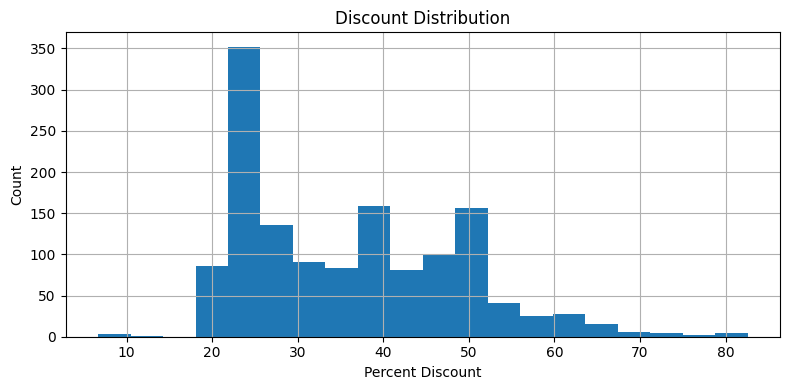

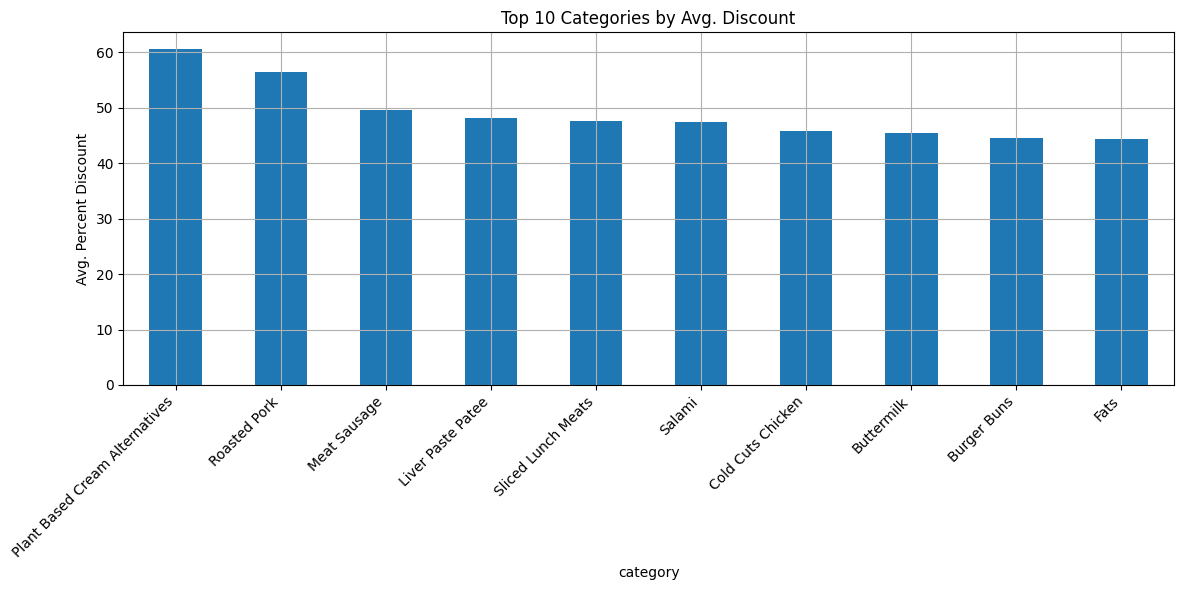

<Figure size 600x400 with 0 Axes>

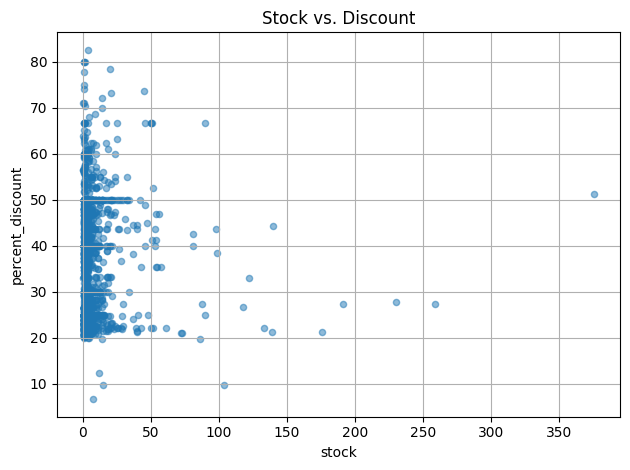


 Average Discount Per Store:
store_name
føtex Nørrebro             45.642636
Tjæpt Blegdamsvej          45.174167
føtex Østerbro Centret     41.145398
Netto Korsørgade           39.717647
føtex City Østerbro        38.337692
føtex City Nørrebrogade    37.924000
Netto Lygten               37.029143
Netto Øbro                 36.681143
føtex City Jagtvej         35.806000
Netto Nørrebrogade 170     35.687368
Name: percent_discount, dtype: float64


In [19]:
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from datetime import datetime

# Inserting API token:
token = "SG_APIM_CM1M3GXGSA98V8PJ19BQDJPM238NHTTS5TVT7JM7Y2E2VEDBFQQ0"
headers = {
    "Authorization": f"Bearer {token}"
}

# Targeted ZIP codes:
target_zips = ['2200', '2400', '2100', '2150', '2500']

# Fetch data
def fetch_food_waste(zip_code):
    url = f"https://api.sallinggroup.com/v1/food-waste/?zip={zip_code}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if data:
            print(f" Success with ZIP {zip_code}")
            return data
        else:
            print(f" Empty data for ZIP {zip_code}")
    else:
        print(f" Error fetching ZIP {zip_code}: {response.status_code}")
    return []

all_data = []
for z in target_zips:
    all_data += fetch_food_waste(z)

# Normalize & Clean Data 
records = []
for store in all_data:
    store_info = store.get('store', {})
    coords = store_info.get('coordinates', [None, None])
    for item in store.get('clearances', []):
        offer = item.get('offer', {})
        product = item.get('product', {})
        full_category = product.get("categories", {}).get("en", "")
        last_category = full_category.split(">")[-1].strip() if full_category else None
        records.append({
            "store_name": store_info.get("name"),
            "store_zip": store_info.get("address", {}).get("zip"),
            "store_street": store_info.get("address", {}).get("street"),
            "lat": coords[1],
            "lon": coords[0],
            "description": product.get("description"),
            "category": last_category,
            "original_price": offer.get("originalPrice"),
            "new_price": offer.get("newPrice"),
            "percent_discount": offer.get("percentDiscount"),
            "stock": offer.get("stock"),
            "start_time": offer.get("startTime"),
            "end_time": offer.get("endTime")
        })

df = pd.DataFrame(records)

#  5. Clean Columns 
df = df.dropna(subset=['description', 'new_price', 'original_price'])
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['money_saved'] = df['original_price'] - df['new_price']

# Descriptive Stats 
print("\n Summary Statistics:")
print(df[['new_price', 'original_price', 'percent_discount', 'stock']].describe())
print("\n Top Categories:")
print(df['category'].value_counts().head(10))



# Histogram of percent discount
plt.figure(figsize=(8, 4))
df['percent_discount'].hist(bins=20)
plt.title("Discount Distribution")
plt.xlabel("Percent Discount")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Top 10 categories by average discount
plt.figure(figsize=(12, 6))
ax = df.groupby('category')['percent_discount'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Categories by Avg. Discount")
plt.ylabel("Avg. Percent Discount")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Stock vs. percent discount
plt.figure(figsize=(6, 4))
df.plot.scatter(x='stock', y='percent_discount', alpha=0.5)
plt.title("Stock vs. Discount")
plt.grid(True)
plt.tight_layout()
plt.show()

# Store discount averages
store_avg = df.groupby('store_name')['percent_discount'].mean().sort_values(ascending=False)
print("\n Average Discount Per Store:")
print(store_avg.head(10))

## Map of stores from the food waste API

The map below allows an user to input an area code and then all the stores which have products on sale are presented on the map.

In [20]:

from IPython.display import display

# Inserting API token
API_TOKEN = "SG_APIM_CM1M3GXGSA98V8PJ19BQDJPM238NHTTS5TVT7JM7Y2E2VEDBFQQ0"  

# ZIP code input:
zip_code = input("Enter a Danish ZIP code (e.g., 8000): ").strip()

# Fetch food waste data 
url = f"https://api.sallinggroup.com/v1/food-waste/?zip={zip_code}"
headers = {"Authorization": f"Bearer {API_TOKEN}"}
response = requests.get(url, headers=headers)

if response.status_code != 200:
    print(f"Error: Failed to fetch data for ZIP {zip_code} ({response.status_code})")
else:
    data = response.json()

    # Extract store coordinates 
    locations = []
    for store_data in data:
        store = store_data.get("store", {})
        coords = store.get("coordinates", [None, None])
        if coords and len(coords) == 2:
            lon, lat = coords
            store_name = store.get("name", "Unknown Store")
            store_address = store.get("address", {}).get("street", "Unknown Address")
            locations.append({
                "name": store_name,
                "address": store_address,
                "lat": lat,
                "lon": lon
            })

    if not locations:
        print(f"No stores found in ZIP {zip_code}.")
    else:
        # Displaying the map
        first = locations[0]
        m = folium.Map(location=[first['lat'], first['lon']], zoom_start=13)
        marker_cluster = MarkerCluster().add_to(m)

        for loc in locations:
            folium.Marker(
                location=[loc['lat'], loc['lon']],
                popup=f"{loc['name']}<br>{loc['address']}",
                icon=folium.Icon(color="green", icon="shopping-cart", prefix="fa")
            ).add_to(marker_cluster)

        display(m)

Error: Failed to fetch data for ZIP 2400 (429)


## Conclusion

This project demonstrates how a combination of modern data tools and AI models can be used to address the ongoing challenge of food waste in the retail sector.

By leveraging live product data from the Salling Group API, we were able to identify clearance items nearing expiration and make them more accessible to consumers through intelligent recommendations. Our solution combines classical analytics with semantic embeddings and a conversational AI-based recipe assistant — creating a hybrid system that adapts to both user preferences and real-time availability.

The semantic recommender allows users to discover similar or discounted alternatives to common products, improving both flexibility and affordability. Meanwhile, the recipe assistant turns a list of selected ingredients into a complete, personalized meal suggestion — and even adapts based on dietary feedback or preferences.

From a business perspective, this system creates a more engaging shopping experience while helping retailers reduce waste. From a consumer standpoint, it saves time, lowers costs, and sparks inspiration in the kitchen.

While we faced limitations such as limited access to real user behavior, API constraints, and daily data variation, the results show strong potential for real-world application and future expansion — such as dietary filtering, quantity-aware pricing, or user-facing interfaces.

This work illustrates how AI can be used not only to make shopping smarter, but also more sustainable.
